## Blending Degrader demo

author: Shuang Liang

This notebook demonstrate the use of `rail.creation.degradation.unrec_bl_model`, which uses Friends of Friends to finds sources close to each other and merge them into unrecognized blends

In [1]:
from rail.creation.degraders.unrec_bl_model import UnrecBlModel

from rail.core.data import PqHandle
from rail.core.stage import RailStage

import matplotlib.pyplot as plt
import pandas as pd, numpy as np

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True


### Create a random catalog with ugrizy+YJHF bands as the the true input

In [3]:
data = np.random.normal(23, 3, size = (1000,12))
data[:, 0] = np.random.uniform(low=0, high=0.03, size=1000)
data[:, 1] = np.random.uniform(low=0, high=0.03, size=1000)

data_df = pd.DataFrame(data=data,    # values
            columns=['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'y', 'Y', 'J', 'H', 'F'])

data_truth_handle = DS.add_data('input', data_df, PqHandle)
data_truth = data_truth_handle.data

In [4]:
#data_df.to_parquet('bl_test.pq')

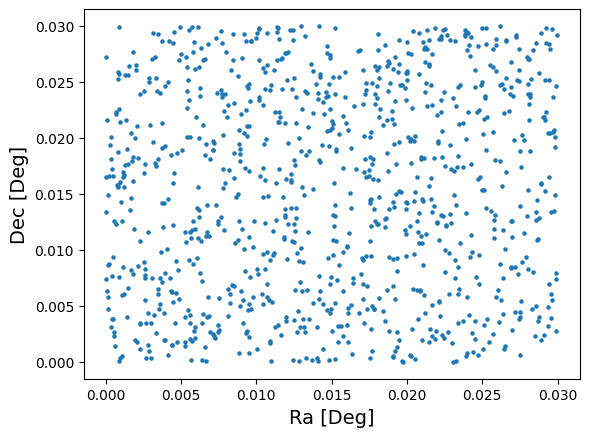

In [5]:
plt.scatter(data_truth['ra'], data_truth['dec'], s=5)
plt.xlabel("Ra [Deg]", fontsize=14)
plt.ylabel("Dec [Deg]", fontsize=14)
plt.show()


### The blending model

In [6]:
## model configuration; linking length is in arcsecs

blModel = UnrecBlModel.make_stage(name='unrec_bl_model', ra_label='ra', dec_label='dec', linking_lengths=1.0, \
                                  bands='ugrizy')
blModel.get_config_dict()


{'output_mode': 'default',
 'seed': 12345,
 'ra_label': 'ra',
 'dec_label': 'dec',
 'linking_lengths': 1.0,
 'bands': 'ugrizy',
 'match_size': False,
 'match_shape': False,
 'obj_size': 'obj_size',
 'a': 'semi_major',
 'b': 'semi_minor',
 'theta': 'orientation',
 'name': 'unrec_bl_model',
 'config': None,
 'input': 'None',
 'aliases': {'output': 'output_unrec_bl_model',
  'component_index': 'component_index_unrec_bl_model'}}

In [7]:
# run the model

outputs = blModel(data_truth)

samples_w_bl = outputs['output'].data
component_ind = outputs['compInd'].data


Inserting handle into data store.  output_unrec_bl_model: inprogress_output_unrec_bl_model.pq, unrec_bl_model
Inserting handle into data store.  component_index_unrec_bl_model: inprogress_component_index_unrec_bl_model.pq, unrec_bl_model


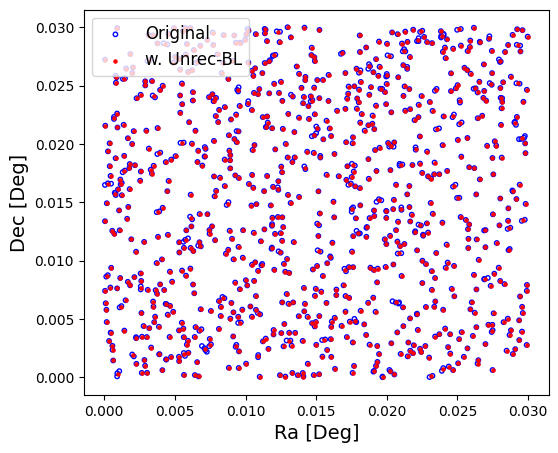

In [8]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

ax.scatter(data_truth['ra'],   data_truth['dec'],   s=10, facecolors='none', edgecolors='b', label='Original')
ax.scatter(samples_w_bl['ra'], samples_w_bl['dec'], s=5, c='r', label='w. Unrec-BL')

ax.legend(loc=2, fontsize=12)
ax.set_xlabel("Ra [Deg]", fontsize=14)
ax.set_ylabel("Dec [Deg]", fontsize=14)

plt.show()


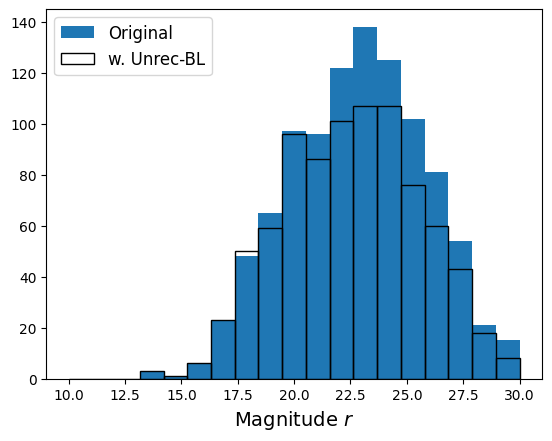

In [9]:
b = 'r'
plt.hist(data_truth[b], bins=np.linspace(10, 30, 20), label='Original')
plt.hist(samples_w_bl[b], bins=np.linspace(10, 30, 20),  fill=False, label='w. Unrec-BL')

plt.xlabel(fr'Magnitude ${b}$', fontsize=14)
plt.legend(fontsize=12)
plt.show()


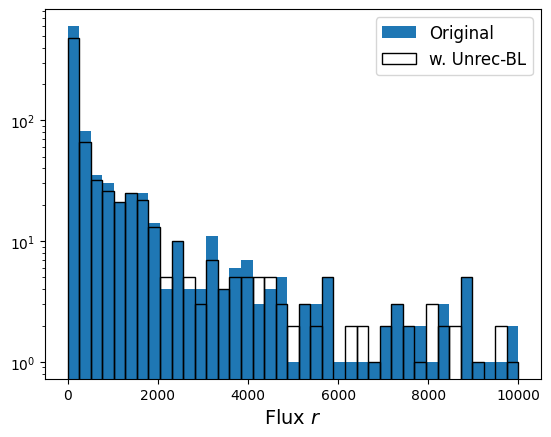

In [10]:
flux = 10**(-(data_truth[b]-28.10)/2.5)       # r band zp for lsst is 28.10
flux_bl = 10**(-(samples_w_bl[b]-28.10)/2.5)

plt.hist(flux, bins=np.linspace(0, 10000, 40), label='Original')
plt.hist(flux_bl, bins=np.linspace(0, 10000, 40), fill=False, label='w. Unrec-BL')

plt.xlabel(fr'Flux ${b}$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=12)
plt.show()


### Study one BL case

In [11]:
## find a source with more than 1 truth component

group_size = 1
while group_size==1:

    rand_ind = np.random.randint(len(samples_w_bl))
    this_bl = samples_w_bl.iloc[rand_ind]
    group_id = this_bl['group_id']
    
    FoF_group = component_ind.query(f"group_id == {group_id}")
    group_size = len(FoF_group)

truth_comp = data_truth.iloc[FoF_group.index]

print('Truth RA / Blended RA:')
print(truth_comp['ra'].to_numpy(), '/', this_bl['ra'])
print("")

print('Truth DEC / Blended DEC:')
print(truth_comp['dec'].to_numpy(), '/', this_bl['dec'])
print("")

for b in 'ugrizy':
    print(f'Truth mag {b} / Blended mag {b}:')
    print(truth_comp[b].to_numpy(), '/', this_bl[b])
    print("")
    

Truth RA / Blended RA:
[0.0200558  0.02029998] / 0.02017789268461808

Truth DEC / Blended DEC:
[0.02758961 0.02750847] / 0.02754903710062099

Truth mag u / Blended mag u:
[27.80013286 24.9100882 ] / 24.836811044430853

Truth mag g / Blended mag g:
[28.64682467 19.20418358] / 19.204002183643933

Truth mag r / Blended mag r:
[21.59410809 23.34540471] / 21.396799285333323

Truth mag i / Blended mag i:
[21.06857667 22.45407615] / 20.80129339889516

Truth mag z / Blended mag z:
[21.09781216 20.8760019 ] / 20.228677528714712

Truth mag y / Blended mag y:
[20.30613921 23.82998838] / 20.26465701164023



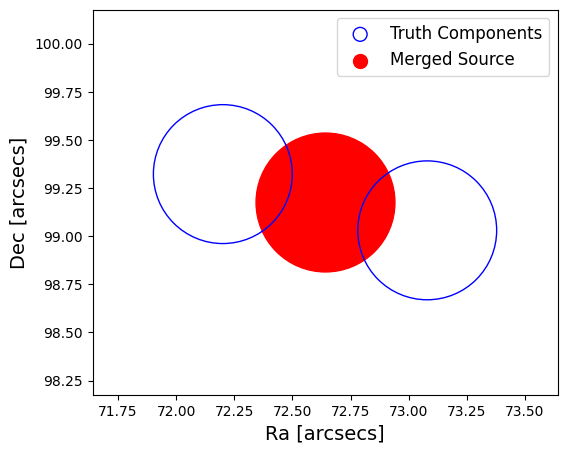

In [12]:

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

ax.scatter(this_bl['ra']*3600, this_bl['dec']*3600, s=1e4, c='r')
ax.scatter(truth_comp['ra']*3600, truth_comp['dec']*3600, s=1e4, facecolors='none', edgecolors='b')

ax.scatter([], [], s=1e2, facecolors='none', edgecolors='b', label='Truth Components')
ax.scatter([], [], s=1e2, c='r', label='Merged Source')

fig_size = 1   ## in arcsecs
ax.set_xlim(this_bl['ra']*3600-fig_size, this_bl['ra']*3600+fig_size)
ax.set_ylim(this_bl['dec']*3600-fig_size, this_bl['dec']*3600+fig_size)

ax.legend(fontsize=12)
ax.set_xlabel("Ra [arcsecs]", fontsize=14)
ax.set_ylabel("Dec [arcsecs]", fontsize=14)

plt.show()
